## Set Up

In [18]:
!pip install -q kaggle


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [19]:
# Move kaggle.json to ~/.kaggle and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download and unzip the competition data
# Download and unzip the competition data
!kaggle competitions download -c playground-series-s5e6
!unzip -o -q playground-series-s5e6.zip -d data/

In [20]:
import os
os.listdir('data')

['test.csv', 'train.csv', 'sample_submission.csv']

## Playground Series S5E6 - Binary Classification
This notebook explores the tabular dataset for Kaggle Playground Series S5E6. The goal is to predict the `Class` column using machine learning, with performance evaluated using ROC AUC.

In [21]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [22]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

print(train.shape)
print(test.shape)
train.head()

(750000, 10)
(250000, 9)


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [23]:
print("Missing values:\n", train.isnull().sum())
print("\nClass distribution:\n", train['Fertilizer Name'].value_counts())

Missing values:
 id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

Class distribution:
 Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64


In [24]:
# encoding 
from sklearn.preprocessing import LabelEncoder

le_soil = LabelEncoder()
le_crop = LabelEncoder()
le_target = LabelEncoder()

train['Soil Type'] = le_soil.fit_transform(train['Soil Type'])
train['Crop Type'] = le_crop.fit_transform(train['Crop Type'])
train['Fertilizer Name'] = le_target.fit_transform(train['Fertilizer Name'])

test['Soil Type'] = le_soil.transform(test['Soil Type'])
test['Crop Type'] = le_crop.transform(test['Crop Type'])


In [25]:
fertilizer_classes = le_target.classes_

In [26]:
# train test split
from sklearn.model_selection import train_test_split

X = train.drop(columns=['id', 'Fertilizer Name'])
y = train['Fertilizer Name']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Baseline model (random forest)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.17      0.20      0.18     22777
           1       0.17      0.21      0.19     22887
           2       0.17      0.19      0.18     22491
           3       0.16      0.17      0.17     22178
           4       0.16      0.16      0.16     22232
           5       0.16      0.11      0.13     18972
           6       0.15      0.09      0.12     18463

    accuracy                           0.17    150000
   macro avg       0.16      0.16      0.16    150000
weighted avg       0.16      0.17      0.16    150000



# Trying XGBoost

In [27]:
from xgboost import XGBClassifier
model = XGBClassifier(tree_method="hist", eval_metric="mlogloss", use_label_encoder=False)

model.fit(X_train, y_train)

/Users/yuliaanashkina/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:28:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [28]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.23      0.21     22777
           1       0.19      0.25      0.22     22887
           2       0.20      0.23      0.21     22491
           3       0.19      0.19      0.19     22178
           4       0.19      0.21      0.20     22232
           5       0.20      0.13      0.16     18972
           6       0.19      0.09      0.12     18463

    accuracy                           0.19    150000
   macro avg       0.19      0.19      0.19    150000
weighted avg       0.19      0.19      0.19    150000



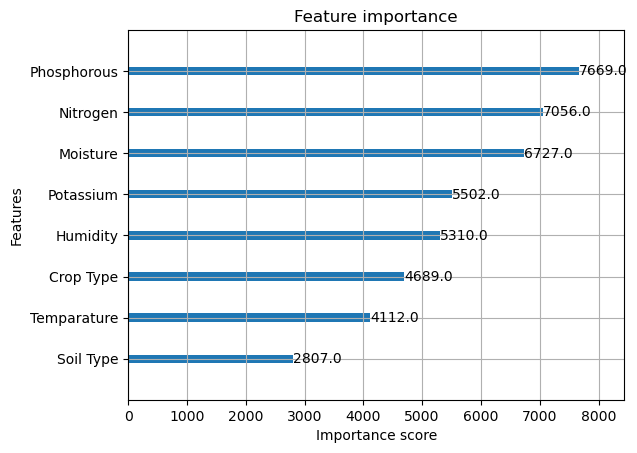

In [29]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model, max_num_features=10)
plt.show()

In [ ]:
X_test = test.drop(columns=["id"])
test_preds = model.predict(X_test)
test_preds_labels = le_target.inverse_transform(test_preds)

submission = sample_submission.copy()
submission["Fertilizer Name"] = test_preds_labels
submission.to_csv("submission_xgboost.csv", index=False)
submission.head()